#Анализ Ribo-seq
##Ира Макарова, декабрь 2022

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
! conda install -c bioconda bcbio-gff

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.simplefilter("ignore", UserWarning)

###1. Определение дифференциальной экспрессии

В архиве хранится файл 01. RiboSeq_RNASeq_HCC_counts.tsv, в
котором содержится матрица каунтов результатов Ribo-Seq и RNA-Seq
экспериментов больных гепатоцеллюлярной карциномой. Матрица каунтов
была получена стандартным воркфлоу STAR. На каждого пациента приходится
4 столбца в таблице (RNA-Seq нормы и опухоли, Ribo-Seq нормы и опухоли),
записанные в виде sample_number-tissue_type-experiment.


In [ ]:
# Загружаем и распаковываем данные
!gdown 1iqYLFVKySREVm5Kn5NagMeHaDi-dVLcj
!unzip HSE_RiboSeq_HT.zip

In [ ]:
# Матрица каунтов
counts = pd.read_csv("HSE_RiboSeq_HT/01. RiboSeq_RNASeq_HCC_counts.tsv", index_col=0, sep="\t")
genes = list(counts["geneSymbol"])
counts = counts.fillna(0)
genes = list(counts["geneSymbol"])
counts.head()

,geneSymbol,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
geneID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.14,TSPAN6,0,0,402,873,0,0,301,1627,0,...,218,457,0,0,200,889,0,0,161,857.0
ENSG00000000005.5,TNMD,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0.0
ENSG00000000419.12,DPM1,168,239,88,187,114,439,66,201,325,...,92,170,109,357,60,244,141,173,56,83.0
ENSG00000000457.13,SCYL3,65,121,60,106,36,163,70,156,130,...,127,176,67,176,55,261,64,100,68,176.0
ENSG00000000460.16,C1orf112,8,43,18,70,16,76,4,63,44,...,124,437,7,167,34,201,6,61,9,58.0


####1.1 (1 балл). Для каждого гена найдите коэффициент корреляции числа каунтов между экспериментами RNA-Seq и Ribo-Seq. Какую корреляцию вы выберете — Пирсона или Спирмена? Обратите внимание, что перед вами не нормированные на глубину библиотеки каунты, учтите это при анализе.


Лучше подходит корелляция Спирмана, так как данные не нормированы, могут включать выбросы (коэффициент корреляции Пирсона особенно чувствителен к выбросам).

In [ ]:
rpf = counts[[col for col in list(counts.columns) if 'RPF' in col]]
rna = counts[[col for col in list(counts.columns) if 'RNA' in col]]

In [ ]:
corr = []
for i in range(len(counts)):
  corr.append(stats.spearmanr(rna.iloc[i], rpf.iloc[i])[0])
corr = pd.Series(corr)

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [ ]:
corr.describe()

count    16859.000000
mean         0.484383
std          0.289355
min         -0.599996
25%          0.307372
50%          0.534288
75%          0.711462
max          1.000000
dtype: float64

####1.2 (1 балл). Постройте гистограмму распределения этих коэффициентов корреляции. Для каких генов корреляция самая высокая, а для каких — самая низкая? Как вы можете это объяснить?

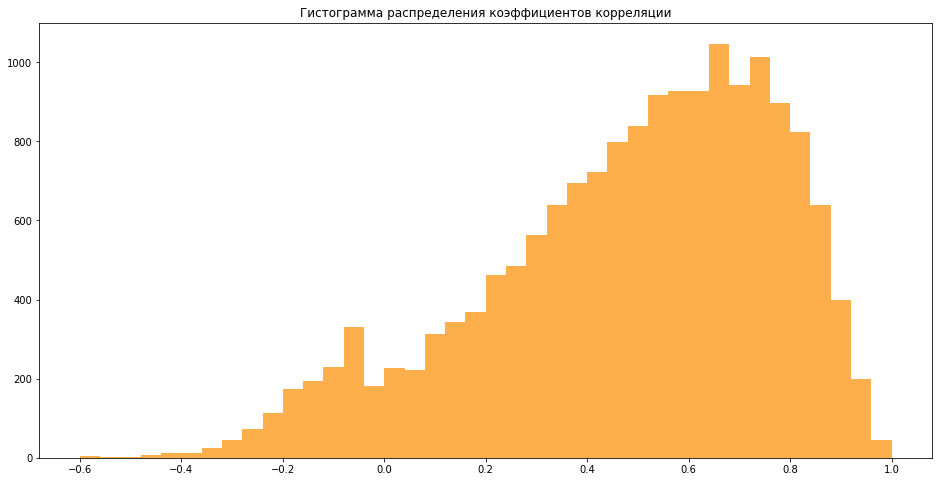

In [ ]:
plt.figure(figsize=(16, 8))
plt.hist(corr, bins=40, color = "darkorange", alpha=0.7, lw=0)
plt.title("Гистограмма распределения коэффициентов корреляции")
plt.show()

In [ ]:
# Избавимся от NAN
corr_clean = corr.fillna(0)
sum(corr_clean.isna())

0

In [ ]:
# Добавим в матрицу каунтов 
counts['corr'] = np.array(corr_clean)
counts['corr_raw'] = np.array(corr)
# Отобразим 15 генов с высокой корреляцией
counts.sort_values('corr', ascending=False).head(15)

,geneSymbol,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,...,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA,corr,corr_raw
geneID,,,,,,,,,,,,,,,,,,,,,
ENSG00000143105.6,KCNA10,0,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
ENSG00000176746.6,MAGEB6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
ENSG00000124935.3,SCGB1D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
ENSG00000251258.1,RFPL4B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,35,0,27.0,1.000000,1.000000
ENSG00000156575.2,PRG3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
ENSG00000174016.11,FAM46D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,4.0,1.000000,1.000000
ENSG00000176040.13,TMPRSS7,0,0,0,0,6,0,2,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
ENSG00000178690.2,DYNAP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
ENSG00000215274.5,GAGE10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000


Гены с высокой корреляцией:
* Все гены с корреляцией, равной 1, почти не экспрессированы, то есть данные по ним сильно разряжены. Это дает высокий коэффициент корреляции. <br> К таким генам относятся ассоцированные с редкими болезнями (например, MAGEB6, ассоциированный с меланомой) либо экспрессируемые в специфических процессах (KCNA10, потенциал-управляемые калиевые каналы) или тканях (SCGB1D2, скелетная мускулатура). <br>
* Многие гены с высокой, но не равной 1, корреляцией относятся к  постоянно активным клеточным процессам,  например, активации гранулоцитов, процессу биосинтеза гистамина, регуляции экспрессии генов (PRG4), связыванию лактозы (LGALS4).
* Некоторые гены, например, CYP7A1 видимо связаны с конкретным экспериментом - гепатоцеллюлярной карциномой. Ген кодируют белок, участвующих в многих метаболических процессах, метаболизме лекарств, жиров. С учетом его функции и паттерна экспрессии (явно значительно больше экспрессирован в норме, чем в опухоли) можно предположить, что это значимый для данного эксперимента ген, высоко экспрессированный как в рамках RNA-seq, Ribo-Seq.

In [ ]:
# Отобразим 15 генов с низкой корреляцией
counts[abs(counts['corr_raw']) < 0.01].sort_values('corr').head(15)

,geneSymbol,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,...,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA,corr,corr_raw
geneID,,,,,,,,,,,,,,,,,,,,,
ENSG00000121716.18,PILRB,1,0,28,4,0,5,25,9,0,...,0,5,38,50,1,0,18,39.0,-0.009916,-0.009916
ENSG00000141873.10,SLC39A3,18,64,59,63,57,32,30,31,48,...,6,76,47,118,8,14,39,55.0,-0.009808,-0.009808
ENSG00000203722.7,RAET1G,0,0,30,11,4,0,0,0,0,...,0,0,0,0,3,0,0,0.0,-0.009537,-0.009537
ENSG00000186010.18,NDUFA13,93,215,31,47,107,259,63,48,165,...,29,61,71,61,17,36,64,44.0,-0.009036,-0.009036
ENSG00000070047.11,PHRF1,65,87,220,51,56,214,236,173,159,...,37,123,285,209,45,45,257,157.0,-0.008280,-0.008280
ENSG00000159409.14,CELF3,0,5,0,0,1,0,8,0,7,...,0,0,0,3,0,0,0,4.0,-0.008169,-0.008169
ENSG00000158517.13,NCF1,1,3,3,1,0,0,4,0,19,...,8,0,4,0,0,5,2,1.0,-0.008081,-0.008081
ENSG00000080224.17,EPHA6,0,0,1,0,10,0,7,1,0,...,0,0,5,0,0,0,0,0.0,-0.007979,-0.007979
ENSG00000115850.9,LCT,0,0,14,8,0,3,6,0,0,...,0,0,0,0,0,0,0,1.0,-0.007947,-0.007947


Среди мало скоррелированных генов есть те, экспрессия которых в Рибо-сек эксперименте оказалась небольшой, но которые экспрессируются по РНК-сек данным (PDZD7, PILRB). Это может быть связано как со случайными факторами, так и с особенностями трансляции (например, в случае низкой эффективности трансляции гена).

####1.3 (1 балл). Проанализируйте распределение каунтов Ribo-seq: постройте зависимость дисперсии от среднего. Похоже ли это на NB-распределение? Если нет, то на какое похоже? Если да, то какие статистические тесты можно использовать для подтверждения того, что перед вами NB-распределение?

In [ ]:
# Посчитаем дисперсию и среднее
var = np.var(rpf, axis = 1)
mean = np.mean(rpf, axis = 1)
mean = mean[var > 0]
var = var[var > 0]

Text(0, 0.5, 'дисперсия')

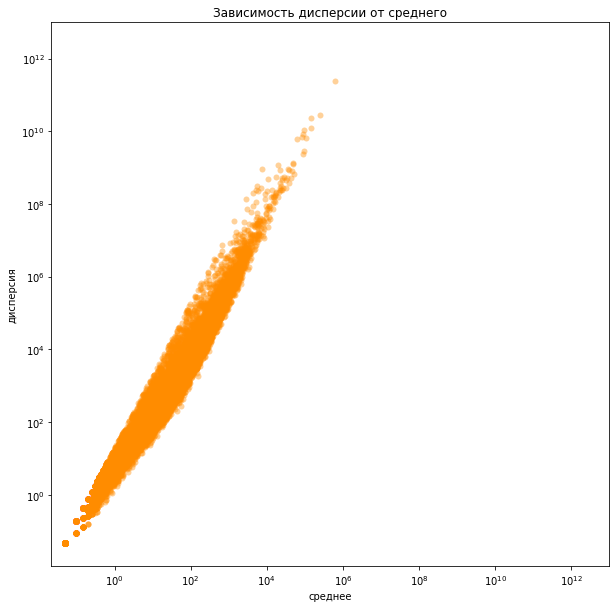

In [ ]:
# Построим заивисимость
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x = mean, y = var, color = "darkorange", alpha=0.4, lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0, 10e12])
ax.set_ylim([0, 10e12])
plt.title("Зависимость дисперсии от среднего")
plt.xlabel("среднее")
plt.ylabel("дисперсия")

Исходя из графика видно, что это отрицательное биноминаьлное распределение, так как дисперсия увеличивается значительно быстрее, чем среднее. 

In [ ]:
# Проверим, действительно ли распределение отрицательное биноминальное. Идея заключается в том, чтобы создать 2 модели - основанную на отрицательном биноминаьном и не основанную, и сравнить их метрики, например, BIC. 
# Код ниже адаптирован из статьи - https://timeseriesreasoning.com/contents/negative-binomial-regression-model/)
# Пуассон
poisson_training_results = sm.GLM(np.log(var + 1), np.log(mean + 1), family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                17349
Model:                            GLM   Df Residuals:                    17348
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40412.
Date:                Thu, 15 Dec 2022   Deviance:                       20445.
Time:                        15:54:05   Pearson chi2:                 2.19e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4096      0.001    732.419      0.0

In [ ]:
poisson_training_results.bic

/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


-148894.00054066366

In [ ]:
# NB 
nb_training_results = sm.GLM(np.log(var + 1), np.log(mean + 1),family=sm.families.NegativeBinomial()).fit()
print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                17349
Model:                            GLM   Df Residuals:                    17348
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48923.
Date:                Thu, 15 Dec 2022   Deviance:                       2990.7
Time:                        15:54:05   Pearson chi2:                 3.01e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4625      0.002    230.695      0.0

In [ ]:
nb_training_results.bic

/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


-166348.12527279506

По показателю BIC модель, основанная на отрицательном биноминальном распределении, лучше отражает данные.

####1.4 (3 балла). Найдите дифференциально экспрессированные гены по RNA-Seq между нормой и опухолью. Для этого можете использовать DESeq2 или edgeR (для DESeq есть обёртка на Python). Постройте volcano plot. То же самое сделайте и для Ribo-Seq эксперимента. Совпадают ли результаты дифференциальной экспрессии? Какие гены оказались значимо различны по экспрессии в одном случае, а какие — в другом? Проведите похожий анализ, только с поиском генов с разницей в эффективности трансляции (~ method + condition + method:condition). Что вы скажете о наборе генов, который вы получили этим методом? Выводы подкрепите графиками.

In [ ]:
# Матрица
# Код ниже написан на основании материалов курса
design = pd.DataFrame({
    "condition": [sample_name.split("-")[1] for sample_name in rna.columns],
}, index=rna.columns)

design.head()

,condition
LC001-normal-RNA,normal
LC001-tumor-RNA,tumor
LC033-normal-RNA,normal
LC033-tumor-RNA,tumor
LC034-normal-RNA,normal


In [ ]:
design.shape

(20, 1)

In [ ]:
# Изначально я пробовала установить обертку на R в colab, но не удалось, пользовалась Rmagic 
from rpy2 import robjects as ro
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

RNA-seq

In [ ]:
# Данные для Deseq
with localconverter(ro.pandas2ri.converter):
    countData = pandas2ri.py2rpy(rna.astype(int))
    colData = pandas2ri.py2rpy(design)

In [ ]:
# Подключаем магию и передаем данные в R
%load_ext rpy2.ipython
%Rpush countData
%Rpush colData

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# Устанавливаем DESeq2
%%R
if (!require("BiocManager", quietly = TRUE))
   install.packages("BiocManager")

BiocManager::install("DESeq2")

library(DESeq2)

In [ ]:
# DESeq2
%%R
dds = DESeqDataSetFromMatrix(countData=countData, 
                             colData=colData, 
                             design=~condition)
dds = DESeq(dds)

In [ ]:
# Получаем результаты
%%R
to_dataframe = function(x) data.frame(x)
res_rna = results(dds)
dds_results = to_dataframe(results(dds))
summary(res_rna)


out of 18443 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3477, 19%
LFC < 0 (down)     : 2552, 14%
outliers [1]       : 0, 0%
low counts [2]     : 1798, 9.7%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
%Rpull dds_results

In [ ]:
with localconverter(pandas2ri.converter):
    dds_results_rna = ro.conversion.rpy2py(dds_results)
    dds_results_rna.index = genes

In [ ]:
dds_results_rna

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,406.279268,1.016935,0.396326,2.565906,1.029066e-02,0.038159
TNMD,0.255801,-0.756176,3.025600,-0.249926,8.026445e-01,NaN
DPM1,105.871975,0.636650,0.319406,1.993232,4.623607e-02,0.120018
SCYL3,104.480304,0.305490,0.238250,1.282226,1.997634e-01,0.348097
C1orf112,62.812560,1.553462,0.547881,2.835400,4.576828e-03,0.020282
...,...,...,...,...,...,...
RP1-34B20.21,10.083912,4.424619,0.799486,5.534333,3.124156e-08,0.000002
RP11-511P7.5,37.107729,0.602483,0.415340,1.450575,1.468982e-01,0.279452
KLF18,0.614809,-2.986452,2.990443,-0.998665,3.179569e-01,NaN
TRBV6-2,0.000000,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log$_{10}$FDR')

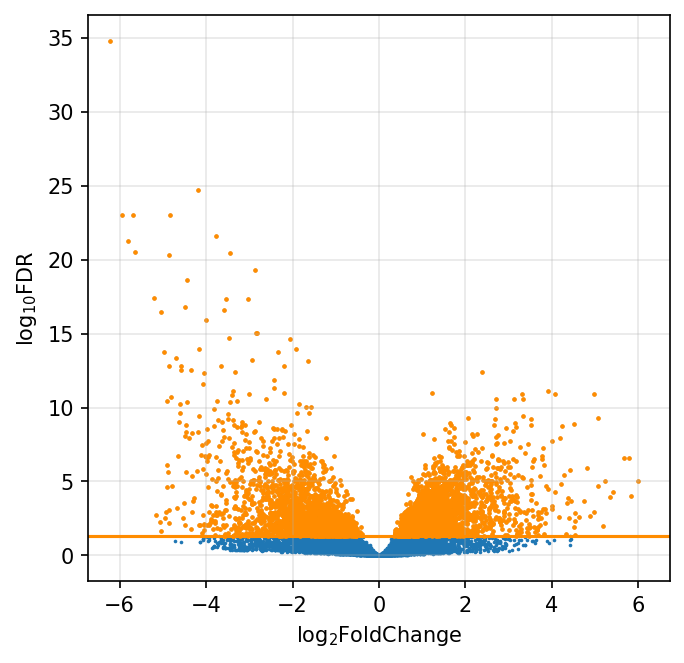

In [ ]:
# Volcano plot
p_tr = 0.05

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(dds_results_rna.log2FoldChange), (max(dds_results_rna.log2FoldChange))) + 0.5

sns.scatterplot(
    x=dds_results_rna.log2FoldChange,
    y=-np.log10(dds_results_rna.padj),
    ax=ax,
    s=3,
    linewidth=0,
)

ax.plot(
    [-xlim, xlim],
    [-np.log10(p_tr), -np.log10(p_tr)],
    color="darkorange",
)

sns.scatterplot(
    x=dds_results_rna[dds_results_rna.padj < p_tr].log2FoldChange,
    y=-np.log10(dds_results_rna[dds_results_rna.padj < p_tr].padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="darkorange",
)

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

Ribo-Seq

In [ ]:
# Матрица
design = pd.DataFrame({
    "condition": [sample_name.split("-")[1] for sample_name in rpf.columns],
}, index=rpf.columns)

design.head()

,condition
LC001-normal-RPF,normal
LC001-tumor-RPF,tumor
LC033-normal-RPF,normal
LC033-tumor-RPF,tumor
LC034-normal-RPF,normal


In [ ]:
design.shape

(20, 1)

In [ ]:
# Данные для Deseq
with localconverter(ro.pandas2ri.converter):
    countData = pandas2ri.py2rpy(rpf.astype(int))
    colData = pandas2ri.py2rpy(design)

In [ ]:
# Подключаем магию и передаем данные в R
#%load_ext rpy2.ipython
%Rpush countData
%Rpush colData

In [ ]:
# DESeq2
%%R
dds = DESeqDataSetFromMatrix(countData=countData, 
                             colData=colData, 
                             design=~condition)
dds = DESeq(dds)

In [ ]:
# Получаем результаты
%%R
res_rpf = results(dds)
dds_results_rpf = data.frame(results(dds))
summary(res_rpf)


out of 17300 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2158, 12%
LFC < 0 (down)     : 1329, 7.7%
outliers [1]       : 0, 0%
low counts [2]     : 3387, 20%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
%Rpull dds_results_rpf

In [ ]:
with localconverter(pandas2ri.converter):
    dds_results_rpf = ro.conversion.rpy2py(dds_results_rpf)
    dds_results_rpf.index = genes

In [ ]:
dds_results_rpf

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,0.000000,NaN,NaN,NaN,NaN,NaN
TNMD,0.134227,-0.497105,3.026188,-0.164268,0.869521,NaN
DPM1,187.335949,-0.111414,0.207386,-0.537228,0.591110,0.750365
SCYL3,88.779354,0.055055,0.245021,0.224694,0.822217,0.904063
C1orf112,42.182053,1.367345,0.481942,2.837153,0.004552,0.030767
...,...,...,...,...,...,...
RP1-34B20.21,0.154862,0.626800,3.020013,0.207549,0.835581,NaN
RP11-511P7.5,4.416458,3.562810,1.221427,2.916924,0.003535,0.025481
KLF18,0.000000,NaN,NaN,NaN,NaN,NaN
TRBV6-2,1.040643,0.921821,2.795457,0.329757,0.741584,NaN


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log$_{10}$FDR')

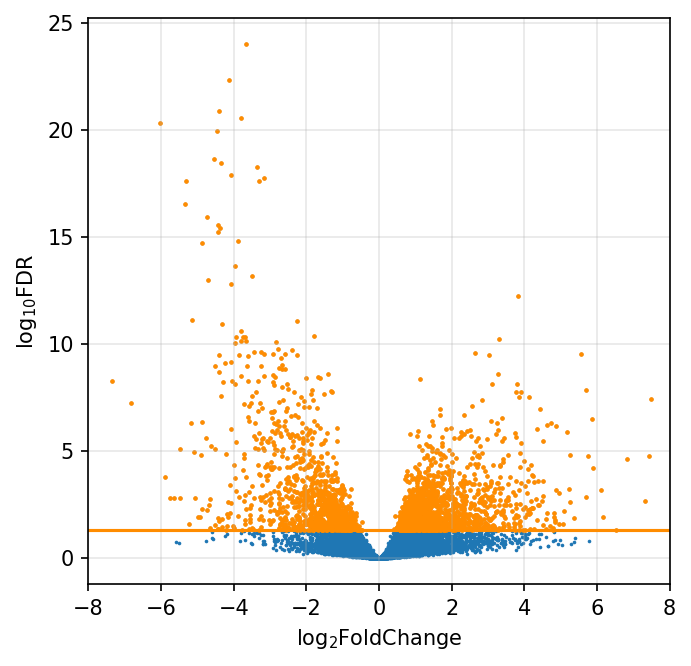

In [ ]:
# Volcano plot
p_tr = 0.05

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = 8

sns.scatterplot(
    x=dds_results_rpf.log2FoldChange,
    y=-np.log10(dds_results_rpf.padj),
    ax=ax,
    s=3,
    linewidth=0,
)

ax.plot(
    [-xlim, xlim],
    [-np.log10(p_tr), -np.log10(p_tr)],
    color="darkorange",
)

sns.scatterplot(
    x=dds_results_rpf[dds_results_rpf.padj < p_tr].log2FoldChange,
    y=-np.log10(dds_results_rpf[dds_results_rpf.padj < p_tr].padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="darkorange",
)

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

Данные экспрессии не совсем совпадают: из графиков видно, что в RNA-seq эксперименте больше значимых генов (генов с большим p-value), чем в Ribo-Seq эксперименте. Сравним количество и посмотрим, совпадают ли они.

In [ ]:
# Количество значимых генов
rna_genes = dds_results_rna[dds_results_rna["padj"] < 0.05]
rpf_genes = dds_results_rpf[dds_results_rpf["padj"] < 0.05]
len(rna_genes), len(rpf_genes) # Разница почти в 2 раза.

(4812, 2543)

In [ ]:
# Посмотрим, пересекаются ли значимые гены в 2 экспериментах
both_genes = set(rna_genes.index) & set(rpf_genes.index)
len(both_genes) # В целом неплохо, большая часть значимых генов пересекаютсяв экспериментах

1630

In [ ]:
# Посмотрим значимые гены в RNA-seq эксперименте
rna_genes.sort_values('pvalue').head(10).index

Index(['CLEC4G', 'OIT3', 'AVPR1A', 'INS-IGF2', 'FCN2', 'CFP', 'CLEC4M', 'HAMP',
       'CETP', 'FCN3'],
      dtype='object')

Информация о некоторых значимых генах:
* CLEC4G - member of the C-type lectin family which plays a role in the immune response
* OIT3 - Oncoprotein
* AVPR1A - arginine vasopressin
* INS-IGF2 - Insulin-Like Growth Factor, hormone activity
* FCN2 - ficolin, predominantly expressed in the liver <br>

Среди генов можно найти специфичные для рака/ печени/ иммунной системы, то есть объясняемые нашими данными. Но в целом, можно сказать, что несколько "шумные" результаты.

In [ ]:
# Посмотрим значимые гены в Ribo-seq эксперименте
rpf_genes.sort_values('pvalue').head(10).index

Index(['CETP', 'OIT3', 'TIMD4', 'ADGRA3', 'CLEC4M', 'CRHBP', 'IGF1', 'APOF',
       'LYVE1', 'HAO2'],
      dtype='object')

Информация о некоторых значимых генах:
* CETP - Cholesteryl Ester Transfer Protein, ipid binding and lipid transporter activity
* TIMD4 - Oncoprotein
* TIMD4OIT3 - immune response including phagocytosis of apoptotic cells and T-cell regulation
* ADGRA3 - Adhesion G Protein-Coupled Receptor, play a role in tumor angiogenesis
* CLEC4M - Probable pathogen-recognition receptor involved in peripheral immune surveillance in liver <br>

Большинство из них специфичны для рака. <br>

Основные выводы:
* В целом результаты Рибо-сек выглядят гораздо более информативными.
* Некоторые значимые гены пересекаются, наверное, они интресснее всего для дальнейшего анализа.

In [ ]:
# Посмотрим значимые гены в обоих экспериментах
list(both_genes)[:20]

['SLC22A11',
 'SHISA4',
 'MCL1',
 'OLFML2A',
 'IRF4',
 'MSH2',
 'SEC14L4',
 'CCDC170',
 'BDH2',
 'SRD5A3',
 'STK24',
 'PTK2',
 'SPON2',
 'IL18RAP',
 'MMP11',
 'SP5',
 'VSIG4',
 'MASP1',
 'AVPR1A',
 'EPRS']

Гены не отсортированы по p-value. Информация о некоторых (возможно, не самых значимых) генах:
* SLC22A11 - kidney
* MCL1 - Apoptosis Regulator, связан с раками

Ribo-Seq + RNA-Seq

In [ ]:
# Матрица
design = pd.DataFrame({
    "condition": [sample_name.split("-")[1] for sample_name in counts.iloc[:,1:].columns],
    "experiment": [sample_name.split("-")[2] for sample_name in counts.iloc[:,1:].columns],
}, index=counts.iloc[:,1:].columns)

design.head()

,condition,experiment
LC001-normal-RPF,normal,RPF
LC001-tumor-RPF,tumor,RPF
LC001-normal-RNA,normal,RNA
LC001-tumor-RNA,tumor,RNA
LC033-normal-RPF,normal,RPF


In [ ]:
design.shape

(40, 2)

In [ ]:
# Данные для Deseq
with localconverter(ro.pandas2ri.converter):
    countData = pandas2ri.py2rpy(counts.iloc[:,1:].astype(int))
    colData = pandas2ri.py2rpy(design)

In [ ]:
# Подключаем магию и передаем данные в R
#%load_ext rpy2.ipython
%Rpush countData
%Rpush colData

In [ ]:
# DESeq2
%%R
dds = DESeqDataSetFromMatrix(countData=countData, 
                             colData=colData, 
                             design=~ condition + experiment + experiment:condition)
dds = DESeq(dds)

In [ ]:
# Получаем результаты
%%R
#to_dataframe = function(x) data.frame(x)
res_both = results(dds)
dds_results_both = data.frame(results(dds))
summary(res_both)


out of 18941 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 34, 0.18%
LFC < 0 (down)     : 18, 0.095%
outliers [1]       : 0, 0%
low counts [2]     : 2208, 12%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
%Rpull dds_results_both

In [ ]:
with localconverter(pandas2ri.converter):
    dds_results_both = ro.conversion.rpy2py(dds_results_both)
    dds_results_both.index = genes

In [ ]:
dds_results_both

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log$_{10}$FDR')

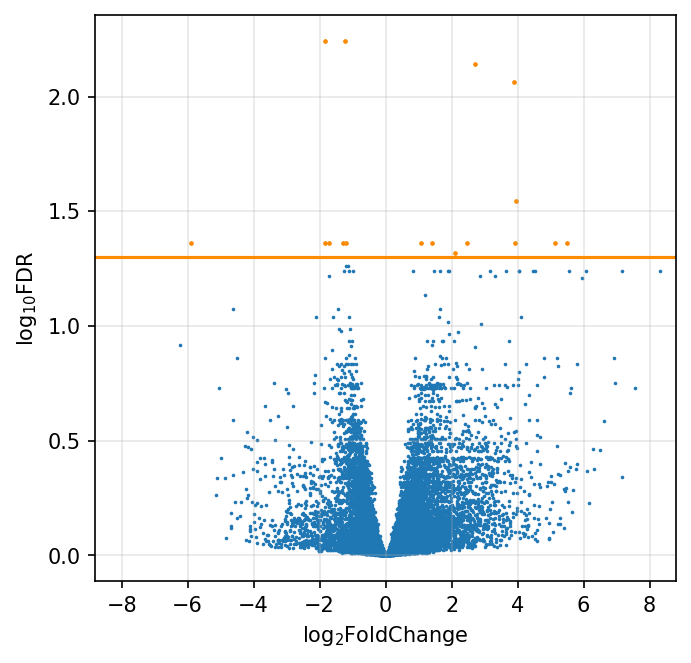

In [ ]:
# Volcano plot
p_tr = 0.05

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(dds_results_both.log2FoldChange), (max(dds_results_both.log2FoldChange))) + 0.5

sns.scatterplot(
    x=dds_results_both.log2FoldChange,
    y=-np.log10(dds_results_both.padj),
    ax=ax,
    s=3,
    linewidth=0,
)

ax.plot(
    [-xlim, xlim],
    [-np.log10(p_tr), -np.log10(p_tr)],
    color="darkorange",
)

sns.scatterplot(
    x=dds_results_both[dds_results_both.padj < p_tr].log2FoldChange,
    y=-np.log10(dds_results_both[dds_results_both.padj < p_tr].padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="darkorange",
)

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

Значимых генов (генов с большим p-value) на порядки меньше, чем в отдельных экспериментах. Это связано с большим объемом данных и, как следствие, поправкой на множественное тестирование. Посмотрим их количество и функции некоторых.

In [ ]:
# Количество значимых генов
b_genes = dds_results_both[dds_results_both["padj"] < 0.05]
len(b_genes)

17

In [ ]:
# Посмотрим значимые гены
b_genes.sort_values('pvalue').head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
UAP1,524.937253,-1.852040,0.372283,-4.974812,6.531085e-07,0.005695
DMXL1,292.358919,-1.242948,0.250249,-4.966847,6.805028e-07,0.005695
DPP9,19998.727349,2.699844,0.557605,4.841855,1.286329e-06,0.007176
CDC25A,28.822459,3.896988,0.820834,4.747594,2.058507e-06,0.008613
KIAA1211L,9.758817,3.937915,0.884599,4.451639,8.521747e-06,0.028526
PNPT1,133.578122,-1.285736,0.298884,-4.301787,1.694259e-05,0.043249
ADGRA3,383.500667,-1.831565,0.428650,-4.272871,1.929719e-05,0.043249
NKX3-2,5.226597,5.505710,1.295173,4.250944,2.128714e-05,0.043249
AKAP11,340.262495,-1.205712,0.285576,-4.222027,2.421147e-05,0.043249
LRRC19,7.684755,-5.908371,1.408787,-4.193943,2.741465e-05,0.043249


Информация о некоторых значимых генах:
* UAP1 - associated with Galactosemia
* DMXL1 - upregulated in cultured cells that overexpress growth factor independence 1B, a transcription factor that is essential for hematopoietic cell development
* DPP9 - have been linked to a variety of diseases including type 2 diabetes, obesity and cancer
* CDC25A - oncogene

Есть гены, ассоциированные с раком, онкогены.

###2. Анализ wig-файла

В архиве (https://drive.google.com/file/d/1iqYLFVKySREVm5Kn5NagMeHaDi-dVLcj/view?usp=sharing) хранятся два файла с .wig-трэками Ribo-Seq эксперимента
кишечной палочки: 02. RiboSeq_EColi_track_f.wig и 02.
RiboSeq_EColi_track_r.wig для прямой и обратной цепочек
соответственно. Трэки эти были получены следующим образом: сначала
прочтения прошли QC, адаптеры были удалены, а получившиеся «чистые»
риды были откартированы на геном кишечной палочки. Затем каждой
геномной позиции были присвоены значения, соответствующие числу
3’-концов прочтений, был определён оффсет для определения P-сайта, после
чего скорректированные на этот оффсет значения и были записаны в
wig-файл. Референсный геном, использовавшийся в ходе обработки
прочтений, — U00096.3. Для выполнения заданий вам потребуется его
аннотация (её вы можете найти в GenBank).


####2.1 (2 балла). Присутствует ли в покрытии генома неравномерность? Рассмотрите неравномерность покрытия на примере любого выбранного вами гена. Что вы можете сказать про эту неравномерность? Присутствует ли там периодичность в три нуклеотида? А если взять среднее по большому количеству генов (взяв за точку отсчёта старт-кодон)? Выводы проиллюстрируйте графиками.


In [5]:
# Считываем данные с wig-треками
wig_f = pd.read_csv('HSE_RiboSeq_HT/02. RiboSeq_EColi_track_f.wig', sep='\t')
wig_r = pd.read_csv('HSE_RiboSeq_HT/02. RiboSeq_EColi_track_r.wig', sep='\t')

In [6]:
# Скачиваем аннотацию GenBank
!gdown 1apblUaD29KlZLZ5caGa6-u2GzoEJIk2U

from BCBio import GFF

handle = open("sequence.gff3")
genome = list(GFF.parse(handle, 
                        limit_info = dict(gff_type = ["CDS"])))
handle.close()

Downloading...
From: https://drive.google.com/uc?id=1apblUaD29KlZLZ5caGa6-u2GzoEJIk2U
To: /content/sequence.gff3
100% 2.48M/2.48M [00:00<00:00, 177MB/s]


In [ ]:
# Выбираем ген, изначаьноя выбрала arfA (alternative ribosome-rescue factor A), но по нему очень небольшое покрытие, поменяла на rplQ (ribosomal protein, 3439616-3439999). В IGV покрытие выглядело так:

)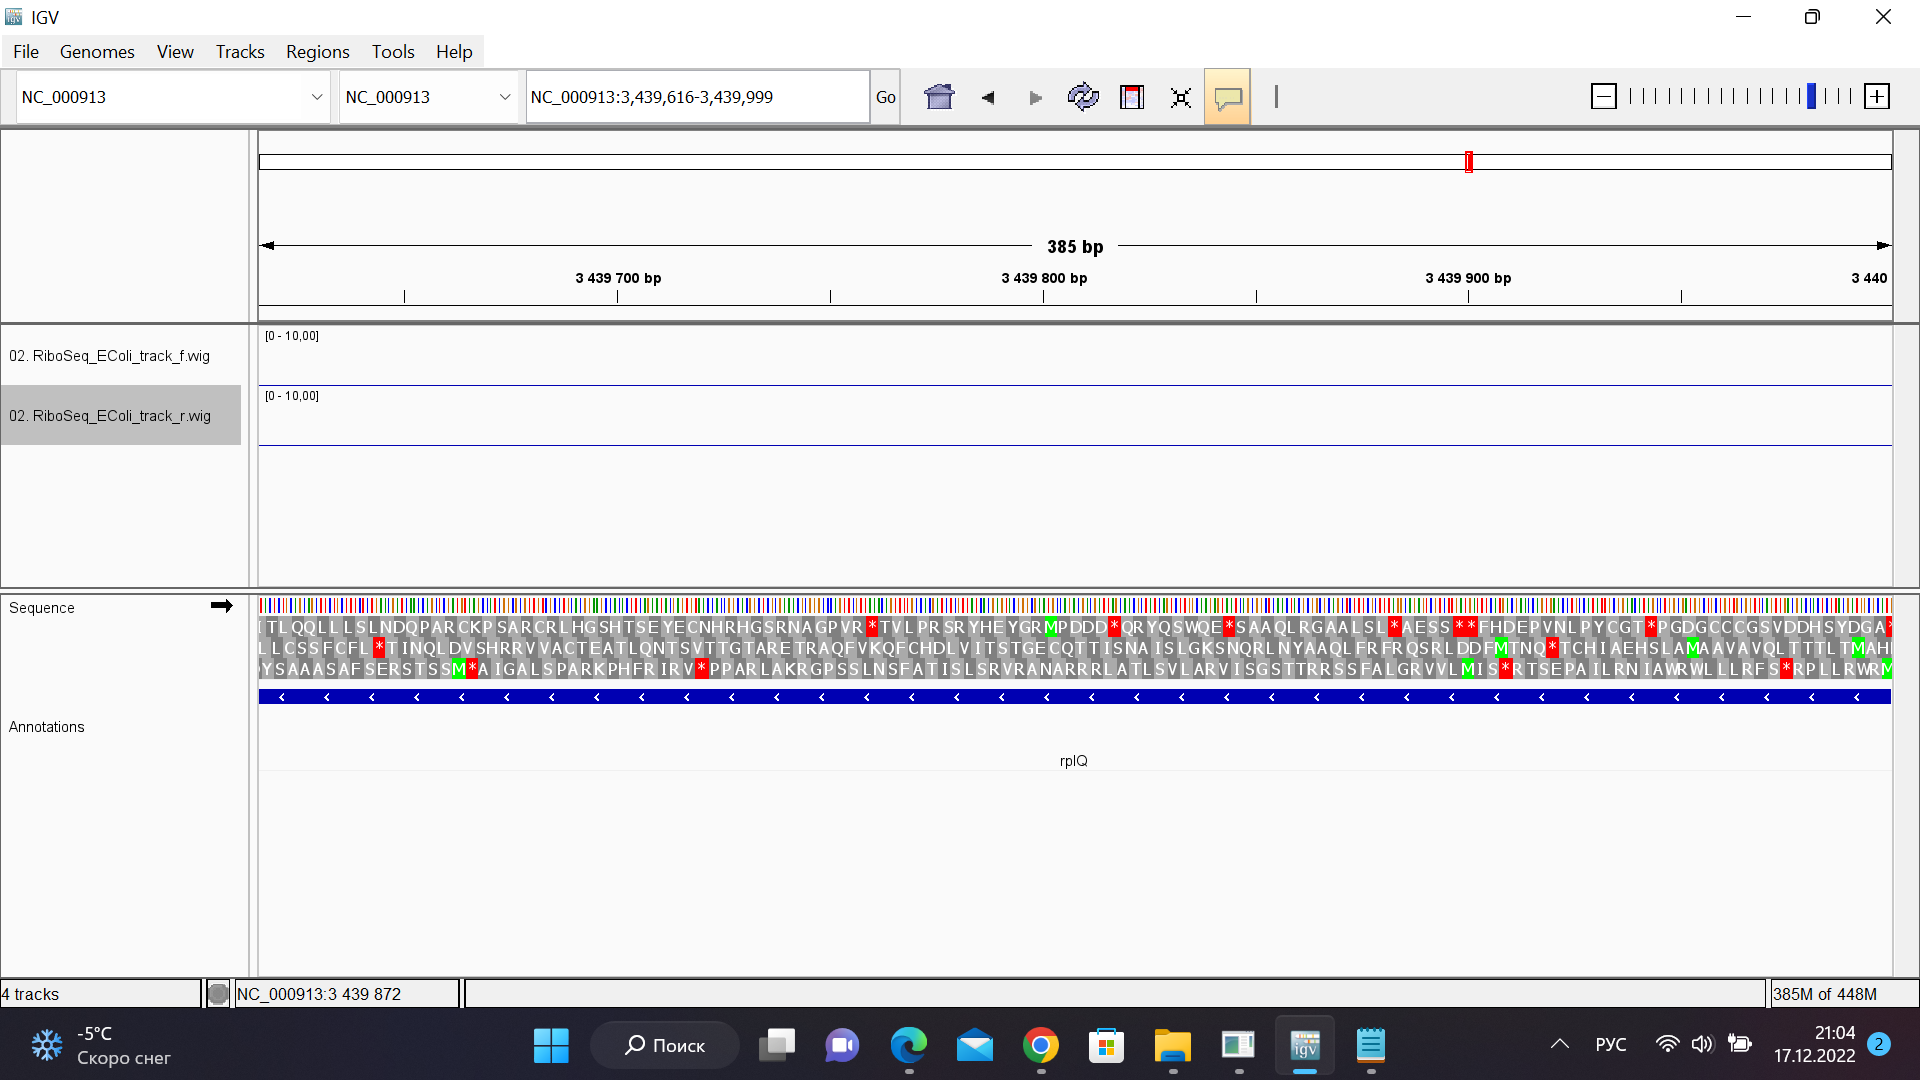

In [7]:
# Видимо, не разобралась я в настройках, покрытия не видно)
# Собираем данные по чтениям для прямой цепочки
len = wig_f[-1:].index[0]
counts_f = np.zeros(len)
with open('HSE_RiboSeq_HT/02. RiboSeq_EColi_track_f.wig', 'r') as file:
  file.readline()
  for line in file:
    pos, count = int(line.split()[0]), int(line.split()[1])
    counts_f[pos-1] = count

In [8]:
# Собираем данные по чтениям для обратной цепочки
counts_r = np.zeros(len)
with open('HSE_RiboSeq_HT/02. RiboSeq_EColi_track_r.wig', 'r') as file:
  file.readline()
  for line in file:
    pos, count = int(line.split()[0]), int(line.split()[1])
    counts_r[pos-1] = count

In [9]:
# Собираем данные из аннотации
cds, start, end, length, strand = [], [], [], [], []
for f in genome[0].features:
    if f.type == "CDS": 
        cds += [f.id]
        start += [f.location.nofuzzy_start]
        end += [f.location.nofuzzy_end]
        len = f.location.nofuzzy_end - f.location.nofuzzy_start + 1
        length += [len]
        if f.strand == 1:
          strand += ['forward']
        else:
          strand += ['reverse']

In [10]:
anno = pd.DataFrame({'cds': cds, 'start': start, 'end': end, 'length': length, 'strand': strand})
anno.head()

,cds,start,end,length,strand
0,cds-AAC73112.1,189,255,67,forward
1,cds-AAC73113.1,336,2799,2464,forward
2,cds-AAC73114.1,2800,3733,934,forward
3,cds-AAC73115.1,3733,5020,1288,forward
4,cds-AAC73116.1,5233,5530,298,forward


In [11]:
# Проверяем для гена rplQ (AAC76319.1)
anno[anno['cds'] == 'cds-AAC76319.1'] # совпадает

,cds,start,end,length,strand
3198,cds-AAC76319.1,3439615,3439999,385,reverse


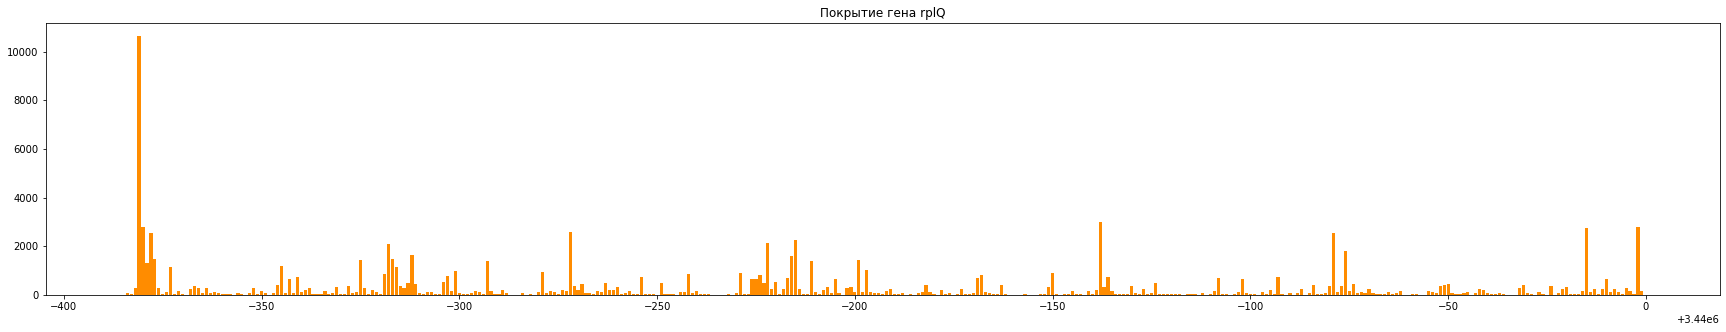

In [ ]:
# Смотрим покрытие для гена rplQ
plt.figure(figsize=(30,5))
plt.bar(wig_r.iloc[474907:475291,:].index, 
        wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'],
        color='darkorange')
plt.title("Покрытие гена rplQ")
plt.show()

Покрытие неравномерное, в начале гена покрытие сильно больше. Это совпадает с тем, что мы ожидалось - рибосома достаточно долго находится на позиции инициации трансляции, соотвественно, ожидалось, что покрытие в начале будет больше. Кроме того, кажется, что есть периодичность ~50pb.

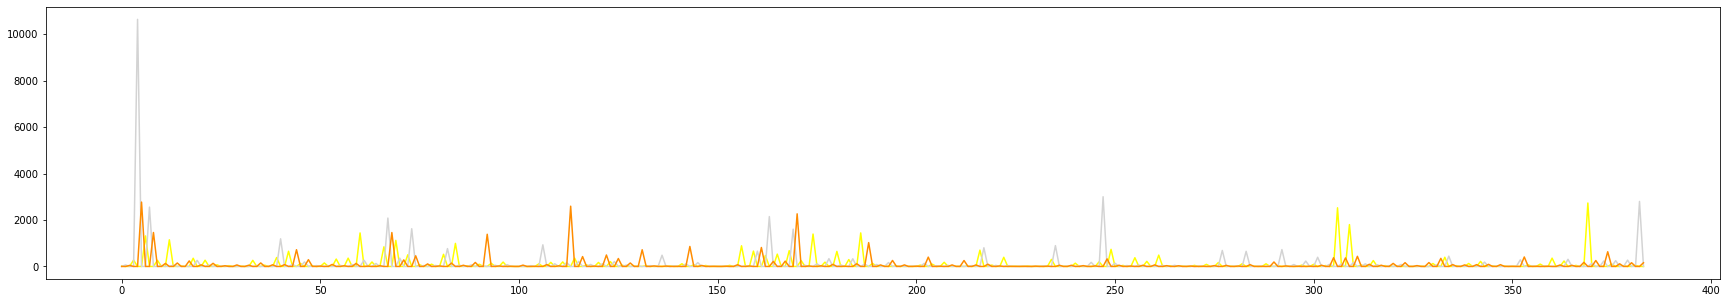

In [ ]:
# Смотрим, есть ли периодичность в 3 нк в конкретном гене
plt.figure(figsize=(30,5))
plt.plot([x if i % 3 == 0 else 0 for i, x in enumerate(wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'])], color="yellow")
plt.plot([x if i % 3 == 1 else 0 for i, x in enumerate(wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'])], color="lightgrey")
plt.plot([x if i % 3 == 2 else 0 for i, x in enumerate(wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'])], color="darkorange")

In [ ]:
print(sum(x if i % 3 == 0 else 0 for i, x in enumerate(wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'])), 
      sum(x if i % 3 == 1 else 0 for i, x in enumerate(wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'])), 
      sum(x if i % 3 == 2 else 0 for i, x in enumerate(wig_r.iloc[474907:475291,:]['variableStep chrom=U00096.3'])))

36049 43809 28826


2-ые нк триплетов покрыты больше всего. При этом покрытие 1нк и 2нк больше, чем 3-его и составляет 73%. То есть да, возникает предположение о неравномерности покрытия и периодичности в 3 нк.

In [71]:
# Смотрим, есть ли периодичность в 3 нк в первых 50 генах
# В данные из wig файлов добоаляем информацию о генах
counts_1, counts_2, counts_3 = 0, 0, 0

for index, cds in anno[:50].iterrows():
  start = int(anno.loc[index, 'start'])
  end = int(anno.loc[index, 'end'])
  strand = anno.loc[index, 'strand']
  if strand == 'forward':
    counts_1 += sum(x if i % 3 == 0 else 0 for i, x in enumerate(wig_f[(wig_f['index'] >= start) & 
                                                                       (wig_f['index'] <= end)]['variableStep chrom=U00096.3']))
    counts_2 += sum(x if i % 3 == 1 else 0 for i, x in enumerate(wig_f[(wig_f['index'] >= start) & 
                                                                       (wig_f['index'] <= end)]['variableStep chrom=U00096.3']))
    counts_3 += sum(x if i % 3 == 2 else 0 for i, x in enumerate(wig_f[(wig_f['index'] >= start) & 
                                                                       (wig_f['index'] <= end)]['variableStep chrom=U00096.3']))
  elif strand == 'reverse':
    counts_1 += sum(x if i % 3 == 0 else 0 for i, x in enumerate(wig_r[(wig_r['index'] >= start) & 
                                                                       (wig_r['index'] <= end)]['variableStep chrom=U00096.3']))
    counts_2 += sum(x if i % 3 == 1 else 0 for i, x in enumerate(wig_r[(wig_r['index'] >= start) & 
                                                                       (wig_r['index'] <= end)]['variableStep chrom=U00096.3']))
    counts_3 += sum(x if i % 3 == 2 else 0 for i, x in enumerate(wig_r[(wig_r['index'] >= start) & 
                                                                       (wig_r['index'] <= end)]['variableStep chrom=U00096.3']))

counts_total = counts_1 + counts_2 + counts_3
counts_1, counts_2, counts_3 = counts_1/counts_total, counts_2/counts_total, counts_3/counts_total

counts_1, counts_2, counts_3

(0.3218867120617963, 0.3242411570234892, 0.3538721309147145)

Не похоже, чтобы существовало значимой периодичности в три нуклеотида.

####2.2 (1 балл). Рассчитайте значения RPKM и TPM для каждого гена. В чём разница между RPKM и TPM?

In [26]:
# Столбец с геномными позициями 
wig_r['index'] = wig_r.index
wig_f['index'] = wig_f.index

In [66]:
# Считаем прочтения для каждого гена
anno['counts'] = 0
for index, cds in anno.iterrows():
  if cds['strand'] == 'forward':
    anno.loc[index, 'counts'] = wig_f[(wig_f['index'] >= int(cds['start'])) &
                          (wig_f['index'] <= int(cds['end']))]['variableStep chrom=U00096.3'].sum()
  elif cds['strand'] == 'reverse':
    anno.loc[index, 'counts'] = wig_r[(wig_r['index'] >= int(cds['start'])) &
                          (wig_r['index'] <= int(cds['end']))]['variableStep chrom=U00096.3'].sum()

anno.head()

,cds,start,end,length,strand,counts
0,cds-AAC73112.1,189,255,67,forward,814
1,cds-AAC73113.1,336,2799,2464,forward,34438
2,cds-AAC73114.1,2800,3733,934,forward,6706
3,cds-AAC73115.1,3733,5020,1288,forward,19625
4,cds-AAC73116.1,5233,5530,298,forward,121


In [68]:
# Cчитаем значения RPKM и TPM
anno['RPKM'], anno['TPM'] = 0, 0
anno['RPKM'] = anno['counts'] / (anno['length'] * anno['counts'].sum()) * 10**9
anno['TPM'] = anno['counts'] / (anno['length'])
anno['TPM'] /= anno['TPM'].sum() / 10**6
anno.head()

,cds,start,end,length,strand,counts,RPKM,TPM
0,cds-AAC73112.1,189,255,67,forward,814,500.760099,299.837951
1,cds-AAC73113.1,336,2799,2464,forward,34438,576.072750,344.932580
2,cds-AAC73114.1,2800,3733,934,forward,6706,295.935310,177.195901
3,cds-AAC73115.1,3733,5020,1288,forward,19625,628.020639,376.037192
4,cds-AAC73116.1,5233,5530,298,forward,121,16.735906,10.020886


* RPKM (Reads per Kilobase per Million reads) - это количество ридов, попавших на ген, скорректированное на длину гена и размер библиотеки. 
* TPM (Transcripts Per Million) - это количество ридов, попавших на ген, скорректированное сначала на длину гена, а затем - на суммы этих значений. <br>

Отличие заключается в том, что в основе RPKM лежит прочтения на 1 ген, в основе TPM - прочтения на 1 нк. В первом случае прочтения нормализуются на общее количество прочтений, приписанных генам. Во втором - на общее количество Е (прочтений на 1 нк).

####2.3 (1 балл). Проанализируйте значения RPKM для генов из оперона ATP. Укажите геномные координаты оперона, а также то, какие гены в него входят. Есть ли разница между RPKM у различных генов, присутствующих в опероне? Как вы можете объяснить эту разницу с биологической точки зрения? Как вы думаете, можно ли оценить эту разницу при помощи классического RNA-Seq

In [113]:
# Находим геномные координаты и то, какие гены входят в ATP
apt = 'ATP synthase'
apt_data = []

for f in genome[0].features:
  if f.type == "CDS": 
    if 'ATP synthase' in f.qualifiers['product'][0]:
      apt_data.append([f.qualifiers['Name'][0], 
                      f.location.start, 
                      f.location.end])

apt_data = pd.DataFrame(apt_data, columns=['cds', 'start', 'end'])
apt_data

,cds,start,end
0,AAC76754.1,3915552,3915972
1,AAC76755.1,3915992,3917375
2,AAC76756.1,3917401,3918265
3,AAC76757.1,3918315,3919857
4,AAC76758.1,3919869,3920403
5,AAC76759.1,3920417,3920888
6,AAC76760.1,3920949,3921189
7,AAC76761.1,3921235,3922051
8,AAC76762.2,3922059,3922440


In [125]:
# RPKM для генов оперона
for index, cds in anno.iterrows():
  if anno.loc[index, 'cds'][4:] == apt_data.loc[0, 'cds']:
    print(index)
    print(anno[index:index+9])
    break

3645
                 cds    start      end  length   strand  counts          RPKM  \
3645  cds-AAC76754.1  3915552  3915972     421  reverse   11584   1134.113623   
3646  cds-AAC76755.1  3915992  3917375    1384  reverse   84201   2507.617393   
3647  cds-AAC76756.1  3917401  3918265     865  reverse   12615    601.106275   
3648  cds-AAC76757.1  3918315  3919857    1543  reverse   73144   1953.857539   
3649  cds-AAC76758.1  3919869  3920403     535  reverse    9528    734.054120   
3650  cds-AAC76759.1  3920417  3920888     472  reverse   12635   1103.350159   
3651  cds-AAC76760.1  3920949  3921189     241  reverse   71406  12212.308798   
3652  cds-AAC76761.1  3921235  3922051     817  reverse   22895   1155.044471   
3653  cds-AAC76762.2  3922059  3922440     382  reverse     519     55.999495   

              TPM  
3645   679.068291  
3646  1501.475182  
3647   359.921795  
3648  1169.902797  
3649   439.526399  
3650   660.648185  
3651  7312.311129  
3652   691.600964  
3653

Видна большая разница между RPKM различных генов, входящих в оперон:
* максимальное значение - cds-AAC76760.1, atpЕ - небольшой ген, ATP synthase subunit c, F1F0 ATP synthase produces ATP from ADP, have 2 components, F1 - the catalytic core - and F0 - the membrane proton channel. F1 has five subunits: alpha3, beta3, gamma1, delta1, epsilon1. F0 has three main subunits: a1, b2 and c10,  (https://www.uniprot.org/uniprotkb/P68699/entry). Ген имеет такую высокую экспрессию из-за важности функции, которую выполняет, клетке необходимо много соответствующих белков.
* минимальное значение - cds-AAC76762.2, atpI,  guide the assembly of the membrane sector of the ATPase enzyme complex, annotation score 3/5 (https://www.uniprot.org/uniprotkb/P0ABC0/entry). Невысокая экспрессия может быть связана с тем, что ген выполняет не такую важную функцию. Кроме того, данные по экспрессии могут зависеть от качества аннотации, которое существенно ниже, чем для предыдущего гена. <br>

Предполагаю, что данные РНК-сек не позволили бы оценить разницу в экспресиии, так как оперон транскрибируется целиком, соотвественно, значения RPKM для всех генов оперона были бы сопоставимы.